In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from joblib import dump
from tqdm.auto import tqdm

# Definicja funkcji do tworzenia sekwencji
def create_sequences_with_max_target(X, y, time_steps=100, future_window=100):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - future_window):
        Xs.append(X[i:(i + time_steps)])
        ys.append(max(y[(i + time_steps):(i + time_steps + future_window)]))
    return np.array(Xs), np.array(ys)

# Definicja architektury modelu LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout_rate, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wczytywanie danych
directory = os.getcwd()
feature_columns = ['resultant_acceleration_1', 'resultant_acceleration_2', 
                   'resultant_acceleration_3', 'resultant_velocity1', 
                   'resultant_velocity2', 'resultant_velocity3']
df = pd.concat([pd.read_excel(os.path.join(directory, filename)) for filename in os.listdir(directory) if filename.endswith('.xlsx')], ignore_index=True)

# Oddzielenie cech od zmiennej docelowej przed skalowaniem
features = df[feature_columns]
target = df['Total_GRF']

# Skalowanie tylko cech
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Tworzenie sekwencji
# Creating sequences
time_steps = 100  # Number of time steps in a sequence, adjusted to capture 0.05 seconds of data
future_window = 100  # Window size to look for the maximum value of Total_GRF, capturing 0.05 seconds

X_seq, y_seq = create_sequences_with_max_target(features_scaled, target.values, time_steps, future_window)


X_seq, y_seq = create_sequences_with_max_target(features_scaled, target.values, time_steps, future_window)


# Podział na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Konwersja do tensorów PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Inicjalizacja modelu
model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, num_layers=2, output_dim=1, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Trenowanie modelu
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tepoch:
        for xb, yb in tepoch:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

# Zapisanie modelu i parametrów skalowania
torch.save({
    'model_state_dict': model.state_dict(),
}, 'model.pth')

dump(scaler, 'scaler.joblib')


Epoch 1/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 2/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 3/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 4/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 5/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 6/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 7/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 8/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 9/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 10/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 11/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 12/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 13/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 14/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 15/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 16/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 17/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 18/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 19/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

Epoch 20/20:   0%|          | 0/2448 [00:00<?, ?batch/s]

['scaler.joblib']

In [9]:
from sklearn.metrics import r2_score

def evaluate_model(model, X_test, y_test):
   
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        predictions = model(X_test).view(-1)  # Get the model predictions
    y_test = y_test.view(-1)  # Reshape the true values to match the model predictions

    # Calculate the MSE and R^2
    mse = nn.MSELoss()(predictions, y_test).item()
    r2 = r2_score(y_test.cpu().numpy(), predictions.cpu().numpy())

    return mse, r2

# Ewaluacja modelu
mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor)
print(f'MSE: {mse}, R^2: {r2}')


MSE: 146618.609375, R^2: 0.6752497790649117


In [4]:
importances_rmse = []
importances_r2 = []

for i in range(X_test_tensor.shape[2]):
    X_test_modified = X_test_tensor.clone()
    X_test_modified[:, :, i] = 0  # Zerowanie i-tej cechy
    with torch.no_grad():
        predictions_modified = model(X_test_modified).view(-1)
        predictions_modified_np = predictions_modified.cpu().numpy()

    modified_rmse = calculate_rmse(predictions_modified_np, targets_np)
    modified_r2 = r2_score(targets_np, predictions_modified_np)
    
    importances_rmse.append(base_rmse - modified_rmse)
    importances_r2.append(base_r2 - modified_r2)

# Generowanie wykresów
import matplotlib.pyplot as plt

# Wykres dla RMSE
plt.figure(figsize=(12, 6))
plt.bar(feature_columns, importances_rmse, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance (RMSE)')
plt.title('Feature Importance Based on RMSE')
plt.xticks(rotation=90)
plt.savefig('averaged_permutation_importance_rmse_torch.png', bbox_inches='tight', dpi=300)  # Save Rmse figure
plt.show()

# Wykres dla R^2
plt.figure(figsize=(12, 6))
plt.bar(feature_columns, importances_r2, color='lightgreen')
plt.xlabel('Features')
plt.ylabel('Importance (R^2)')
plt.title('Feature Importance Based on R^2')
plt.savefig('averaged_permutation_importance_r2_torch.png', bbox_inches='tight', dpi=300)  # Save R² figure
plt.xticks(rotation=90)
plt.show()


NameError: name 'calculate_rmse' is not defined

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def feature_importance_analysis(model, X_test, y_test, num_runs=10):
    original_rmse, original_r2 = evaluate_model(model, X_test, y_test)
    rmse_changes = np.zeros((num_runs, len(feature_columns)))
    r2_changes = np.zeros((num_runs, len(feature_columns)))

    for n in range(num_runs):
        for i, feature in enumerate(feature_columns):
            X_test_shuffled = X_test.clone()
            np.random.shuffle(X_test_shuffled[:, :, i].numpy())  # Mieszanie danych dla i-tej cechy
            shuffled_rmse, shuffled_r2 = evaluate_model(model, X_test_shuffled, y_test)
            rmse_changes[n, i] = shuffled_rmse - original_rmse
            r2_changes[n, i] = original_r2 - shuffled_r2  # Uwaga: mniejszy R^2 oznacza większy wpływ

    # Obliczanie średniej zmiany dla każdej cechy
    mean_rmse_changes = np.mean(rmse_changes, axis=0)
    mean_r2_changes = np.mean(r2_changes, axis=0)

    return mean_rmse_changes, mean_r2_changes

# Analiza ważności cech
mean_rmse_changes, mean_r2_changes = feature_importance_analysis(model, X_test_tensor, y_test_tensor, num_runs=10)

# Generowanie wykresów
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Wykres dla RMSE
ax[0].bar(feature_columns, mean_rmse_changes, color='skyblue')
ax[0].set_title('Feature Importance based on RMSE Change')
ax[0].set_xticklabels(feature_columns, rotation=90)
ax[0].set_ylabel('Average Increase in RMSE')
ax[0].set_xlabel('Feature')

# Wykres dla R^2
ax[1].bar(feature_columns, mean_r2_changes, color='salmon')
ax[1].set_title('Feature Importance based on R^2 Change')
ax[1].set_xticklabels(feature_columns, rotation=90)
ax[1].set_ylabel('Average Decrease in R^2')
ax[1].set_xlabel('Feature')

plt.tight_layout()
plt.show()
print("Feature Importance based on RMSE Change:")
for feature, change in zip(feature_columns, mean_rmse_changes):
    print(f"{feature}: {change:.4f}")

print("\nFeature Importance based on R^2 Change:")
for feature, change in zip(feature_columns, mean_r2_changes):
    print(f"{feature}: {change:.4f}")

KeyboardInterrupt: 

Overall Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Shuffling:   0%|          | 0/6 [00:00<?, ?it/s]

Feature Importances based on RMSE:
resultant_acceleration_1: 80194.7391
resultant_acceleration_2: 120319.5844
resultant_acceleration_3: 122136.7625
resultant_velocity1: 193171.2906
resultant_velocity2: 380438.7219
resultant_velocity3: 279309.2812

Feature Importances based on R^2:
resultant_acceleration_1: 0.1776
resultant_acceleration_2: 0.2665
resultant_acceleration_3: 0.2705
resultant_velocity1: 0.4279
resultant_velocity2: 0.8426
resultant_velocity3: 0.6187


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20592\1323193532.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(feature_columns, rotation=90)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20592\1323193532.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(feature_columns, rotation=90)


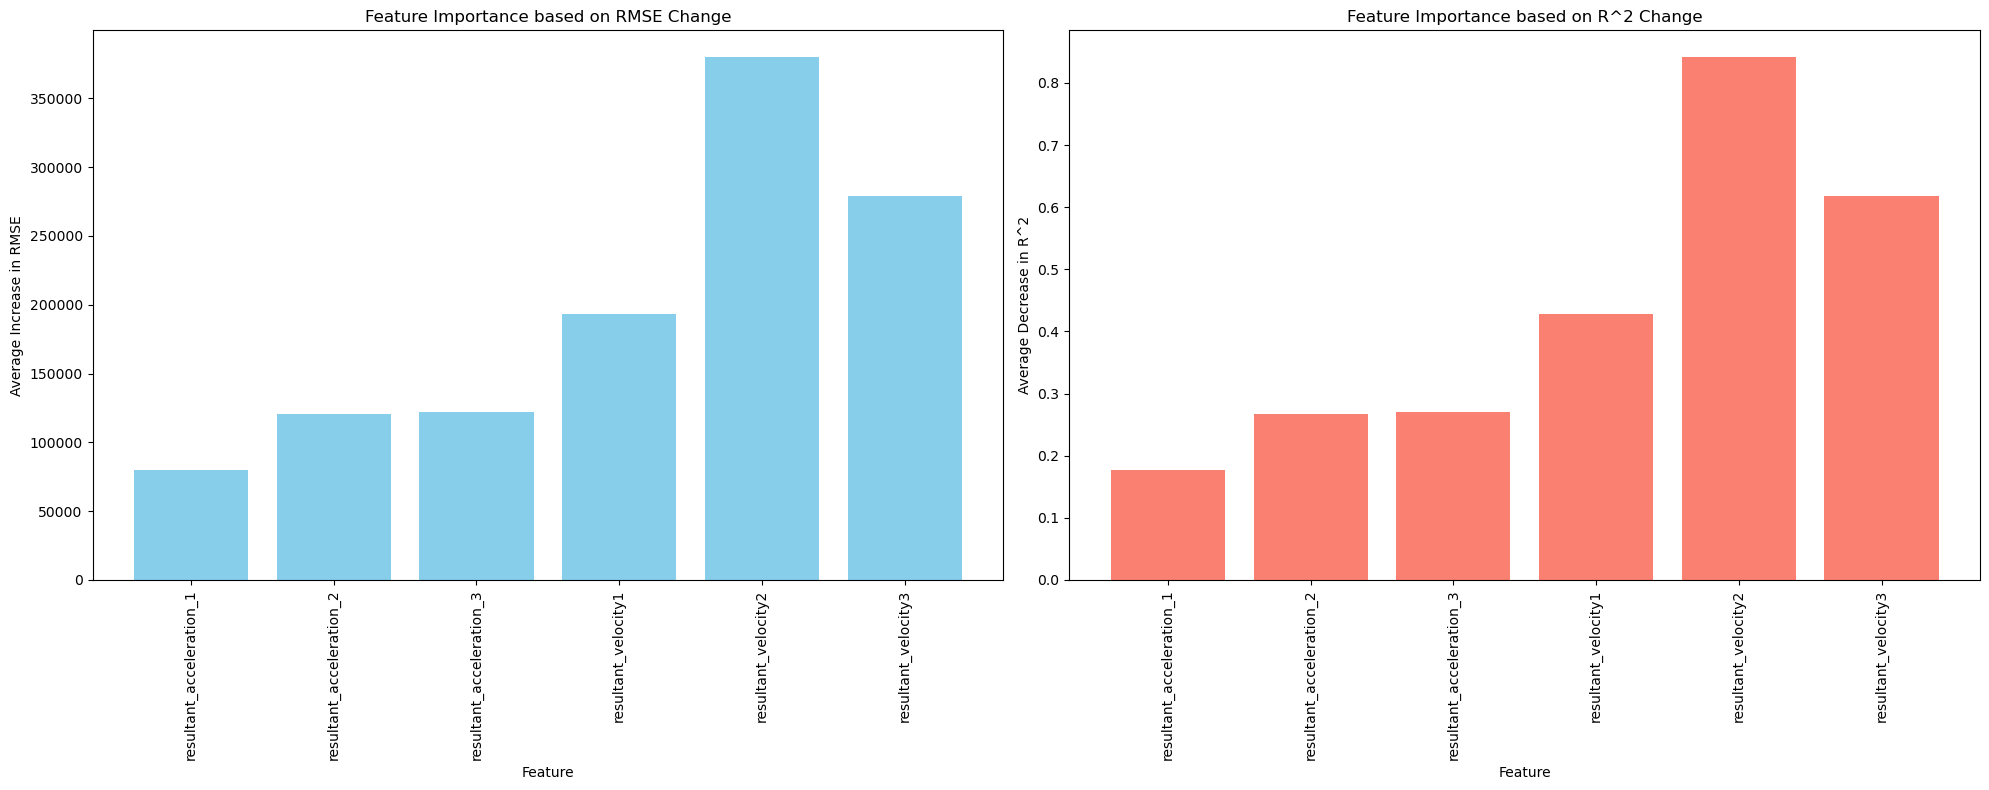

Feature Importance based on RMSE Change:
resultant_acceleration_1: 80194.7391
resultant_acceleration_2: 120319.5844
resultant_acceleration_3: 122136.7625
resultant_velocity1: 193171.2906
resultant_velocity2: 380438.7219
resultant_velocity3: 279309.2812

Feature Importance based on R^2 Change:
resultant_acceleration_1: 0.1776
resultant_acceleration_2: 0.2665
resultant_acceleration_3: 0.2705
resultant_velocity1: 0.4279
resultant_velocity2: 0.8426
resultant_velocity3: 0.6187


In [11]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch.nn as nn

def evaluate_model(model, X_test, y_test):
    model.eval()  # Ustawia model w tryb ewaluacji
    with torch.no_grad():  # Wyłącza obliczanie gradientów
        predictions = model(X_test).view(-1)
    y_test = y_test.view(-1)
    
    # Obliczenie MSE
    mse = nn.MSELoss()(predictions, y_test).item()

    # Konwersja tensorów PyTorch na tablice NumPy do obliczenia R^2
    predictions_np = predictions.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Obliczenie R^2
    r2 = r2_score(y_test_np, predictions_np)
    
    return mse, r2

def feature_importance_analysis(model, X_test, y_test, num_runs=10):
    original_rmse, original_r2 = evaluate_model(model, X_test, y_test)
    rmse_changes = np.zeros((num_runs, len(feature_columns)))
    r2_changes = np.zeros((num_runs, len(feature_columns)))

    for n in tqdm(range(num_runs), desc='Overall Progress'):
        for i, feature in enumerate(tqdm(feature_columns, desc='Feature Shuffling', leave=False)):
            X_test_shuffled = X_test.clone()
            np.random.shuffle(X_test_shuffled[:, :, i].numpy())  # Mieszanie danych dla i-tej cechy
            shuffled_rmse, shuffled_r2 = evaluate_model(model, X_test_shuffled, y_test)
            rmse_changes[n, i] = shuffled_rmse - original_rmse
            r2_changes[n, i] = original_r2 - shuffled_r2  # Uwaga: mniejszy R^2 oznacza większy wpływ

    # Obliczanie średniej zmiany dla każdej cechy
    mean_rmse_changes = np.mean(rmse_changes, axis=0)
    mean_r2_changes = np.mean(r2_changes, axis=0)

    return mean_rmse_changes, mean_r2_changes

# Analiza ważności cech
mean_rmse_changes, mean_r2_changes = feature_importance_analysis(model, X_test_tensor, y_test_tensor, num_runs=10)

# Wyświetlanie wyników
print("Feature Importances based on RMSE:")
for feature, change in zip(feature_columns, mean_rmse_changes):
    print(f"{feature}: {change:.4f}")

print("\nFeature Importances based on R^2:")
for feature, change in zip(feature_columns, mean_r2_changes):
    print(f"{feature}: {change:.4f}")

# Generowanie wykresów
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Wykres dla RMSE
ax[0].bar(feature_columns, mean_rmse_changes, color='skyblue')
ax[0].set_title('Feature Importance based on RMSE Change')
ax[0].set_xticklabels(feature_columns, rotation=90)
ax[0].set_ylabel('Average Increase in RMSE')
ax[0].set_xlabel('Feature')
plt.savefig('averaged_Feature Importance based on RMSE_torch.png', bbox_inches='tight', dpi=300)  # Save R² figure
# Wykres dla R^2
ax[1].bar(feature_columns, mean_r2_changes, color='salmon')
ax[1].set_title('Feature Importance based on R^2 Change')

ax[1].set_xticklabels(feature_columns, rotation=90)
ax[1].set_ylabel('Average Decrease in R^2')
ax[1].set_xlabel('Feature')

plt.tight_layout()
plt.savefig('averaged_Feature Importance based on R^2 Change_torch.png', bbox_inches='tight', dpi=300)  # Save R² figure
plt.show()

print("Feature Importance based on RMSE Change:")
for feature, change in zip(feature_columns, mean_rmse_changes):
    print(f"{feature}: {change:.4f}")

print("\nFeature Importance based on R^2 Change:")
for feature, change in zip(feature_columns, mean_r2_changes):
    print(f"{feature}: {change:.4f}")

In [16]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=2, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout_rate, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming all necessary imports are already done

# Inicjalizacja modelu z odpowiednimi wymiarami
# Since your model is bidirectional, hidden_dim is effectively doubled when connecting to the fully connected layer
model = LSTMModel(input_dim=6, hidden_dim=50, num_layers=2, output_dim=1, dropout_rate=0.3)

# Loading the checkpoint
checkpoint = torch.load('model.pth', map_location=device)

# Loading the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Moving the model to the specified device (GPU or CPU)
model.to(device)

# Ensure the model is in evaluation mode if you're not continuing training
model.eval()



LSTMModel(
  (lstm): LSTM(6, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# Załaduj checkpoint
checkpoint_path = 'model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

# Wydrukuj klucze dostępne w checkpoint
print(checkpoint.keys())



dict_keys(['model_state_dict'])


In [18]:
# Odtworzenie modelu
model = LSTMModel(input_dim=6, hidden_dim=50, num_layers=2, output_dim=1)  # XX to liczba cech wejściowych
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)


LSTMModel(
  (lstm): LSTM(6, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [19]:
model.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [21]:
import pandas as pd
import torch
from joblib import load

# Zakładamy, że masz już wczytany model i jest on gotowy do użycia, a także że 'device' jest zdefiniowane

# Odtworzenie skalera z zapisanego pliku
scaler = load('scaler.joblib')

# Wczytywanie nowego pliku danych
new_data = pd.read_excel('radecki_dollyo_prawe_event_1.xlsx')

# Usuwanie kolumn, które nie były używane podczas skalowania i dopasowywania modelu
new_data_prepared = new_data.drop(['Time', 'Total_GRF'], axis=1)

# Upewnienie się, że kolumny są w tej samej kolejności, co podczas dopasowania skalera
new_data_prepared = new_data_prepared[feature_columns]

# Przeskalowanie nowych danych przy użyciu wcześniej dopasowanego skalera
new_data_scaled = scaler.transform(new_data_prepared)

# Konwersja przeskalowanych danych do tensora PyTorch
# Dodajemy .unsqueeze(0) jeśli przetwarzamy pojedynczy przykład, aby dodać wymiar batchu
new_data_scaled_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device).unsqueeze(0)

# Wykonanie predykcji
model.eval()  # Przełączenie modelu w tryb ewaluacji
with torch.no_grad():  # Wyłączenie obliczania gradientów
    predictions = model(new_data_scaled_tensor).cpu().numpy()

# Wyświetlenie predykcji
print(predictions)


[[6.618538]]


In [ ]:
# Załaduj skalera
scaler = load('scaler.joblib')

# Weź próbkę danych treningowych i przeskaluj je
sample_features = features.iloc[:5]  # Przykładowe wiersze z danych treningowych
sample_features_scaled = scaler.transform(sample_features)

print("Przeskalowane cechy próbki:")
print(sample_features_scaled)


In [ ]:
# Konwersja przeskalowanych cech próbki do tensora PyTorch
sample_features_tensor = torch.tensor(sample_features_scaled, dtype=torch.float32).to(device).unsqueeze(0)

# Wykonaj predykcję na próbce
model.eval()
with torch.no_grad():
    sample_predictions = model(sample_features_tensor).cpu().numpy()

print("Predykcje dla próbki danych treningowych:")
print(sample_predictions)


In [ ]:
# Załóżmy, że masz dane walidacyjne X_val_tensor i y_val_tensor
model.eval()
with torch.no_grad():
    predictions_train = model(X_train_tensor).cpu().numpy()
    predictions_val = model(X_test_tensor).cpu().numpy()

# Możesz obliczyć metryki, takie jak MSE, dla tych predykcji
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, predictions_train)
mse_val = mean_squared_error(y_test, predictions_val)

print(f"MSE dla danych treningowych: {mse_train}")
print(f"MSE dla danych walidacyjnych: {mse_val}")


In [ ]:
# Przykład użycia skalera do przeskalowania nowych danych
features = df[feature_columns]  # Tylko cechy do przeskalowania
target = df['Total_GRF']  # Zmienna docelowa

# Skalowanie tylko cech
from joblib import dump, load

# Zapisanie skalera
dump(scaler, 'scaler.joblib') 

# Odtworzenie skalera
scaler = load('scaler.joblib')

features_scaled = scaler.fit_transform(features)
target_scaled = target.values.reshape(-1, 1)
new_data = pd.read_excel('agata_dollyo_lewa_event_1.xlsx')  # Załaduj nowe dane
# Usuń kolumny 'Time' i 'Total_GRF', które nie były używane podczas dopasowywania skalera
new_data_prepared = new_data.drop(['Time', 'Total_GRF'], axis=1)

# Upewnij się, że kolumny są w tej samej kolejności, co podczas dopasowania skalera
new_data_prepared = new_data_prepared[feature_columns]

# Przeskaluj dane
new_data_scaled = scaler.transform(new_data_prepared)

# Konwersja przeskalowanych danych do tensora PyTorch
new_data_scaled_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)

if new_data_scaled_tensor.dim() == 2:
    new_data_scaled_tensor = new_data_scaled_tensor.unsqueeze(0) 
# Wykonaj predykcję
model.eval()
with torch.no_grad():
    predictions = model(new_data_scaled_tensor).cpu().numpy()

# Wyświetlenie predykcji
print(predictions)

In [ ]:
# Sprawdzenie, czy checkpoint zawiera informacje o skalowaniu
if 'scaler_state_dict' in checkpoint:
    # Odtworzenie stanu skalera
    scaler_mean = checkpoint['scaler_state_dict']['mean']
    scaler_var = checkpoint['scaler_state_dict']['var']
    scaler = StandardScaler()
    scaler.mean_ = np.array(scaler_mean)
    scaler.var_ = np.array(scaler_var)
    scaler.scale_ = np.sqrt(scaler.var_)
    if 'n_samples_seen_' in checkpoint['scaler_state_dict']:
        scaler.n_samples_seen_ = checkpoint['scaler_state_dict']['n_samples_seen_']
else:
    print("Checkpoint nie zawiera danych skalera.")



In [ ]:
import load_model
# Load the model
model = load_model('model_and_scaler.pth')

# Assuming X_new is your new data prepared in the same way as the training data
# For example, you might need to scale the data similarly and reshape it for LSTM input

# Use the loaded model to make predictions
predictions = model.predict(radecki_dollyo_trad_l_event_3.xlsx)

# Process the predictions as needed

In [ ]:
scaler = StandardScaler()
checkpoint = torch.load('model_and_scaler.pth')
model.load_state_dict(checkpoint['model_state_dict'])
scaler = checkpoint['scaler']


In [ ]:
# Ładowanie modelu i parametrów skalowania
checkpoint = torch.load('model_and_scaler.pth')

# Odtwarzanie modelu
model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, num_layers=1, output_dim=1)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Odtwarzanie skalera
scaler = checkpoint['scaler_state_dict']


In [ ]:
# Wczytanie zmodyfikowanego pliku Excel do DataFrame
new_df = pd.read_excel('maja_dollyo_prawe_tarcza_modified_event_1.xlsx')

# Wyświetlenie nazw kolumn, aby upewnić się, że są zgodne z oczekiwaniami
print(new_df.columns.tolist())



In [ ]:
# Wybór cech z DataFrame przy użyciu pierwotnie zdefiniowanych feature_columns
new_features = new_df[feature_columns]

# Skalowanie cech przy użyciu wcześniej załadowanego skalera
new_features_scaled = scaler.transform(new_features)


In [ ]:
# Zakładając, że funkcja create_sequences jest zdefiniowana i time_steps jest ustalony
X_new, _ = create_sequences(new_features_scaled, np.zeros(len(new_features_scaled)), time_steps=3)

# Konwersja do tensorów PyTorch
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)


In [ ]:
# Ustawienie modelu na tryb ewaluacji i wykonanie predykcji
model.eval()
with torch.no_grad():
    predictions = model(X_new_tensor).cpu().numpy()

# Wyniki predykcji
print(predictions)
